Created on Thu Apr 18 05:43:21 2024

@author: Santiago D'hers

Use:

- This script will compare the performance of different trained models

Requirements:

- Models trained with 3a-Create_Models.py
- Access to the file colabeled_data.csv, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [54]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import datetime

import joblib

# from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.models import load_model

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [55]:
desktop = 'C:/Users/dhers/Desktop'
STORM_folder = os.path.join(desktop, 'STORM/models')

colabels_file = os.path.join(STORM_folder, 'colabeled_data.csv')
colabels = pd.read_csv(colabels_file)

before, after = 3, 3
frames = before + after + 1

today = datetime.datetime.now()
# use_model_date = today.date()
use_model_date = '2024-10-16'

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']

In [56]:
def recenter(df, point, bodyparts):
    # Create a copy of the original dataframe
    df_copy = df.copy()
    bodypart_columns = []
    
    for bodypart in bodyparts:
        # Subtract point_x from columns ending in _x
        x_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_x')]
        df_copy[x_cols] = df_copy[x_cols].apply(lambda col: col - df_copy[f'{point}_x'])
        
        # Subtract point_y from columns ending in _y
        y_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_y')]
        df_copy[y_cols] = df_copy[y_cols].apply(lambda col: col - df_copy[f'{point}_y'])
        
        # Collect bodypart columns
        bodypart_columns.extend(x_cols)
        bodypart_columns.extend(y_cols)
        
    return df_copy[bodypart_columns]

In [57]:
def reshape(df, back = before, forward = after): # This function reshapes data for LSTM models
    
    reshaped_df = []
    
    for i in range(0, back):
        reshaped_df.append(df[: 1 + back + forward])
            
    for i in range(back, len(df) - forward):
        reshaped_df.append(df[i - back : 1 + i + forward])
    
    for i in range(len(df) - forward, len(df)):
        reshaped_df.append(df[-(1 + back + forward):])
    
    return reshaped_df

In [58]:
# The labels for left and right exploration are on the rest of the columns, we need to extract them
position = colabels.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy()
                         
lblr_A = colabels.filter(regex='Marian').copy()
lblr_B = colabels.filter(regex='Agus').copy()
lblr_C = colabels.filter(regex='Santi').copy()
lblr_D = colabels.filter(regex='Guille').copy()
lblr_E = colabels.filter(regex='Myself').copy()

labelers = [lblr_A, lblr_B, lblr_C, lblr_D, lblr_E]

geometric = colabels.filter(regex='Geometric').copy() # We dont use the geometric labels to train the model

# Calculate average labels
combined_df = pd.concat(labelers, axis=1)
avrg = pd.DataFrame(combined_df.mean(axis=1), columns=['mean'])

In [59]:
# Load the saved models
model_simple = load_model(os.path.join(STORM_folder, f'simple/model_simple_{use_model_date}.keras'))
model_wide = load_model(os.path.join(STORM_folder, f'wide/model_wide_{use_model_date}.keras'))
RF_model = joblib.load(os.path.join(STORM_folder, f'RF/model_RF_{use_model_date}.pkl'))

In [60]:
def use_model(position, model, objects = ['obj_1', 'obj_2'], bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body'], recentering = True, reshaping = False):
    
    if recentering:
        dfs = []
        for obj in objects:
            recentered = recenter(position, obj, bodyparts)
            dfs.append(recentered)
        position = pd.concat(dfs,ignore_index=True)
    
    if reshaping:
        position = reshape(position, before, after)
        position = np.array([df.values for df in position])
    
    pred = model.predict(position) # Use the model to predict the labels

    num_objects = len(objects)
    # Reshape pred to split into equal parts for each object
    split_size = len(pred) // num_objects
    reshaped_pred = pred.reshape((split_size, num_objects))
    # Create a DataFrame with the reshaped pred and object names as columns
    labels = pd.DataFrame(reshaped_pred, columns=objects)
    
    return labels

In [61]:
X_all = position.copy()

all_simple = use_model(X_all, model_simple, objects=objects)
all_simple_binary = (all_simple >= 0.5).astype(int) 

all_wide = use_model(X_all, model_wide, objects=objects, reshaping = True)
all_wide_binary = (all_wide >= 0.5).astype(int)

all_RF = use_model(X_all, RF_model, objects=objects)

5220/5220 [==============================] - 55s 10ms/step


In [62]:
avrg_binary = (avrg >= 0.5).astype(int)

In [63]:
all_labelers = [all_simple_binary, all_wide_binary, all_RF, lblr_A, lblr_B, lblr_C, lblr_D, lblr_E, geometric]
labelers_names = ['simple', 'wide', 'RF', 'lblr_A', 'lblr_B', 'lblr_C', 'lblr_D', 'lblr_E', 'geometric']

for i, labeler in enumerate(all_labelers):
    accuracy = accuracy_score(labeler, avrg_binary)
    precision = precision_score(labeler, avrg_binary, average='weighted')
    recall = recall_score(labeler, avrg_binary, average='weighted')
    f1 = f1_score(labeler, avrg_binary, average='weighted')
    
    mse = mean_squared_error(labeler, avrg)
    mae = mean_absolute_error(labeler, avrg)
    r2 = r2_score(labeler, avrg)

    # Print evaluation metrics along with the labeler's name
    print(f"Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Mean Squared Error = {mse:.4f}, Mean Absolute Error = {mae:.4f}, R-squared = {r2:.4f} -> {labelers_names[i]}")

Accuracy = 0.9769, Precision = 0.9766, Recall = 0.9769, F1 Score = 0.9767, Mean Squared Error = 0.0184, Mean Absolute Error = 0.0311, R-squared = 0.6883 -> simple
Accuracy = 0.9829, Precision = 0.9825, Recall = 0.9829, F1 Score = 0.9825, Mean Squared Error = 0.0131, Mean Absolute Error = 0.0258, R-squared = 0.7936 -> wide
Accuracy = 0.9866, Precision = 0.9864, Recall = 0.9866, F1 Score = 0.9862, Mean Squared Error = 0.0125, Mean Absolute Error = 0.0252, R-squared = 0.8075 -> RF
Accuracy = 0.9825, Precision = 0.9826, Recall = 0.9825, F1 Score = 0.9815, Mean Squared Error = 0.0108, Mean Absolute Error = 0.0235, R-squared = 0.8482 -> lblr_A
Accuracy = 0.9780, Precision = 0.9857, Recall = 0.9780, F1 Score = 0.9802, Mean Squared Error = 0.0153, Mean Absolute Error = 0.0280, R-squared = 0.5997 -> lblr_B
Accuracy = 0.9702, Precision = 0.9705, Recall = 0.9702, F1 Score = 0.9677, Mean Squared Error = 0.0178, Mean Absolute Error = 0.0305, R-squared = 0.7798 -> lblr_C
Accuracy = 0.9866, Precision

In [64]:
avrg_values = [round(1/len(labelers) * i, 2) for i in range(len(labelers))]

df = pd.DataFrame()

for i in avrg_values:
    df[f"avrg_{i}"] = (avrg > i).astype(int)
for name, data in zip(labelers_names, all_labelers):
    df[name] = data

df

,avrg_0.0,avrg_0.2,avrg_0.4,avrg_0.6,avrg_0.8,simple,wide,RF,lblr_A,lblr_B,lblr_C,lblr_D,lblr_E,geometric
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167007,0,0,0,0,0,0,0,0,0,0,0,0,0,0
167008,0,0,0,0,0,0,0,0,0,0,0,0,0,0
167009,0,0,0,0,0,0,0,0,0,0,0,0,0,0
167010,0,0,0,0,0,0,0,0,0,0,0,0,0,0


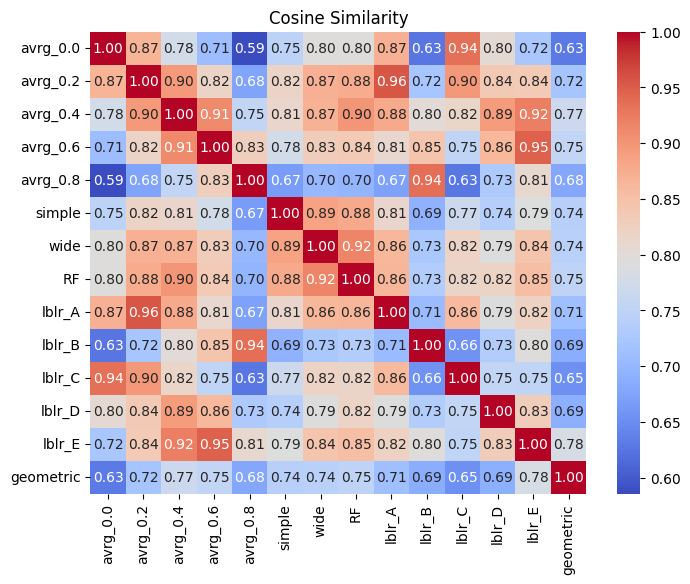

In [65]:
# Compute Cosine similarity

cosine_sim = pd.DataFrame(cosine_similarity(df.T), index=df.columns, columns=df.columns)

# Plot Cosine similarity heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim.astype(float), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity")
plt.show()

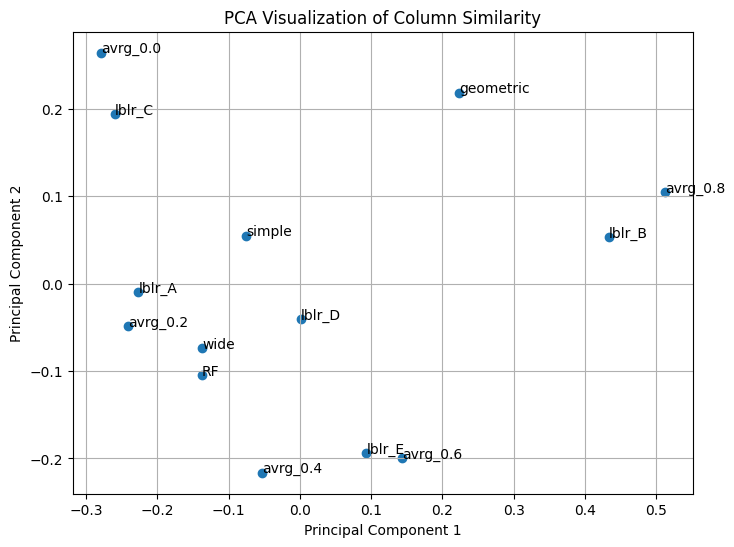

In [66]:
from sklearn.decomposition import PCA

# Use PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cosine_sim)

# Plot the 2D representation
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Annotate the points with column names
for i, column in enumerate(df.columns):
    plt.annotate(column, (pca_result[i, 0], pca_result[i, 1]))

plt.title("PCA Visualization of Column Similarity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

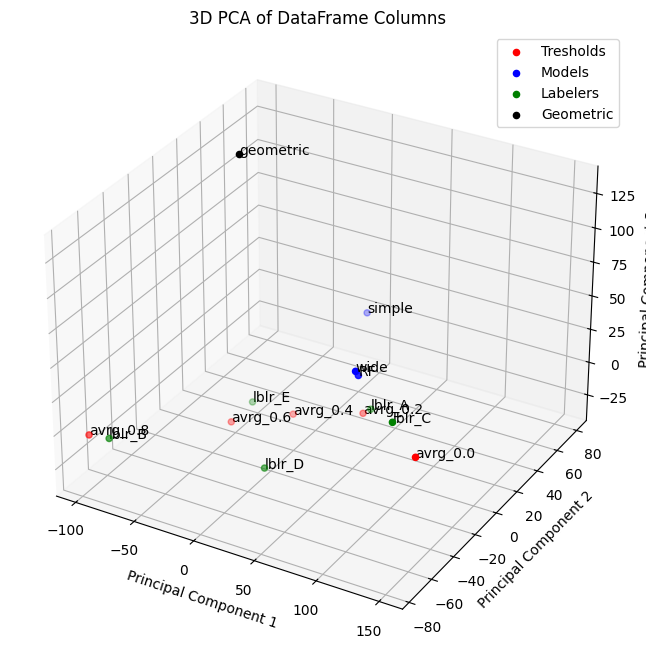

Explained variance ratio: [0.34563153 0.15101974 0.12851453]


In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Transpose the DataFrame to analyze columns
df_transposed = df.T

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_transposed)

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Add the principal components to the original DataFrame
df_pca = pd.concat([df_transposed.reset_index(), pca_df], axis=1)

# Plot the principal components
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the first 5 points in a different color
ax.scatter(pca_df['PC1'][:5], pca_df['PC2'][:5], pca_df['PC3'][:5], color='red', label='Tresholds')
ax.scatter(pca_df['PC1'][5:8], pca_df['PC2'][5:8], pca_df['PC3'][5:8], color='blue', label='Models')
ax.scatter(pca_df['PC1'][8:13], pca_df['PC2'][8:13], pca_df['PC3'][8:13], color='green', label='Labelers')
ax.scatter(pca_df['PC1'][13], pca_df['PC2'][13], pca_df['PC3'][13], color='black', label='Geometric')

for i in range(len(pca_df)):
    ax.text(pca_df['PC1'][i], pca_df['PC2'][i], pca_df['PC3'][i], df_transposed.index[i])

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of DataFrame Columns')
ax.legend()
plt.show()

# Print explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

Now we can use the models in an example video

In [68]:
# Prepare the dataset of a video we want to analyze and see

X_view = pd.read_csv(os.path.join(STORM_folder, 'example/Example_position.csv')).filter(regex='^(?!.*tail)').copy()
video_path = os.path.join(STORM_folder, 'example/Example_video.mp4')

labels_A = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Marian.csv'), usecols=['Left', 'Right'])
labels_B = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Agus.csv'), usecols=['Left', 'Right'])
labels_C = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Santi.csv'), usecols=['Left', 'Right'])
labels_D = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Guille.csv'), usecols=['Left', 'Right'])
labels_E = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Dhers.csv'), usecols=['Left', 'Right'])

"""
labels_A = smooth_column(labels_A)
labels_B = smooth_column(labels_B)
labels_C = smooth_column(labels_C)
labels_D = smooth_column(labels_D)
labels_E = smooth_column(labels_E)
"""

dfs_example = [labels_A, labels_B, labels_C, labels_D, labels_E]

# Calculate average labels
sum_df_example = pd.DataFrame()
for df in dfs_example:
    sum_df_example = sum_df_example.add(df, fill_value=0)
avrg_example = sum_df_example / len(dfs_example)

In [69]:
autolabels_simple = use_model(X_view, model_simple)
autolabels_wide = use_model(X_view, model_wide, reshaping = True)
autolabels_RF = use_model(X_view, RF_model)

469/469 [==============================] - 5s 10ms/step


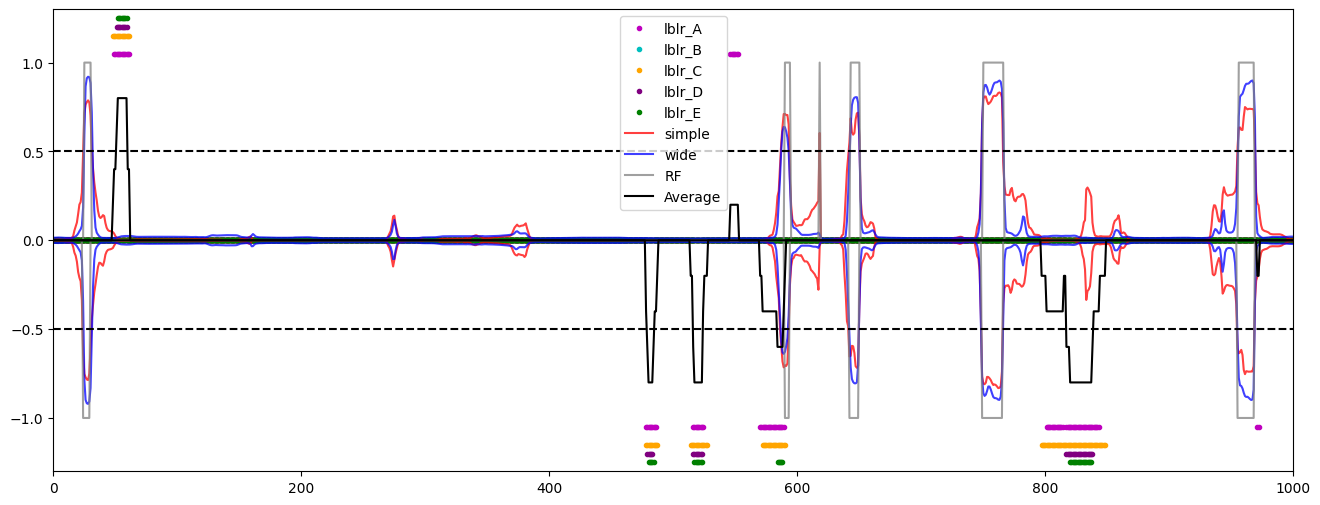

In [73]:
# Lets plot the timeline to see the performance of the model

plt.figure(figsize = (16, 6))

plt.plot(labels_A["Left"] * 1.05, ".", color = "m", label = "lblr_A")
plt.plot(labels_A["Right"] * -1.05, ".", color = "m")

plt.plot(labels_B["Left"] * 1.10, ".", color = "c", label = "lblr_B")
plt.plot(labels_B["Right"] * -1.10, ".", color = "c")

plt.plot(labels_C["Left"] * 1.15, ".", color = "orange", label = "lblr_C")
plt.plot(labels_C["Right"] * -1.15, ".", color = "orange")

plt.plot(labels_D["Left"] * 1.20, ".", color = "purple", label = "lblr_D")
plt.plot(labels_D["Right"] * -1.20, ".", color = "purple")

plt.plot(labels_E["Left"] * 1.25, ".", color = "g", label = "lblr_E")
plt.plot(labels_E["Right"] * -1.25, ".", color = "g")

plt.plot(autolabels_simple["obj_1"], color = "r", alpha = 0.75, label = "simple")
plt.plot(autolabels_simple["obj_2"] * -1, color = "r", alpha = 0.75)

plt.plot(autolabels_wide["obj_1"], color = "b", alpha = 0.75, label = "wide")
plt.plot(autolabels_wide["obj_2"] * -1, color = "b", alpha = 0.75)

plt.plot(autolabels_RF["obj_1"], color = "gray", alpha = 0.75, label = "RF")
plt.plot(autolabels_RF["obj_2"] * -1, color = "gray", alpha = 0.75)

plt.plot(avrg_example["Left"], color = "black", label = "Average")
plt.plot(avrg_example["Right"] * -1, color = "black")

# Zoom in on the labels and the minima of the distances and angles
plt.ylim((-1.3, 1.3))
plt.xlim((0, 1000))
plt.axhline(y=0.5, color='black', linestyle='--')
plt.axhline(y=-0.5, color='black', linestyle='--')

plt.legend()
plt.show()